<a href="https://colab.research.google.com/github/soheilpaper/So-AI-Love-/blob/master/notebooks/1.0-test-noise-reduction_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

#### Download packages if in Google Colab

In [3]:
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",
    "pip install pseudo-microbit",
    "pip install keyboard"

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Test noise reduction algorithm and view steps of algorithm

In [4]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

### Load data

In [5]:
#@title Install dependencies

!pip install -q omegaconf torchaudio pydub

import os
from os.path import exists

if not exists('silero-models'):
  !git clone -q --depth 1 https://github.com/snakers4/silero-models

%cd silero-models

# silero imports
import torch
import random
from glob import glob
from omegaconf import OmegaConf
from src.silero.utils import (init_jit_model, 
                       split_into_batches,
                       read_audio,
                       read_batch,
                       prepare_model_input)
from colab_utils import (record_audio,
                         audio_bytes_to_np,
                         upload_audio)

device = torch.device('cpu')   # you can use any pytorch device
models = OmegaConf.load('models.yml')

# imports for uploading/recording
import numpy as np
import ipywidgets as widgets
from scipy.io import wavfile
from IPython.display import Audio, display, clear_output
from torchaudio.functional import vad


# wav to text method
def wav_to_text(f='test.wav'):
  batch = read_batch([f])
  input = prepare_model_input(batch, device=device)
  output = model(input)
  return decoder(output[0].cpu())

/content/silero-models


In [6]:
#@markdown { run: "auto" }

language = "English" #@param ["English", "German", "Spanish"]

print(language)
if language == 'German':
  model, decoder = init_jit_model(models.stt_models.de.latest.jit, device=device)
elif language == "Spanish":
  model, decoder = init_jit_model(models.stt_models.es.latest.jit, device=device)
else:
  model, decoder = init_jit_model(models.stt_models.en.latest.jit, device=device)

English


In [7]:
#@markdown { run: "auto" }

use_VAD = "No" #@param ["Yes", "No"]

In [8]:
#@markdown Either record audio from microphone or upload audio from file (.mp3 or .wav) { run: "auto" }

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =  8 #@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000
global rec_v
rec_v=0

def _apply_vad(audio, boot_time=0, trigger_level=9, **kwargs):
  print('\nVAD applied\n')
  vad_kwargs = dict(locals().copy(), **kwargs)
  vad_kwargs['sample_rate'] = sample_rate
  del vad_kwargs['kwargs'], vad_kwargs['audio']
  audio = vad(torch.flip(audio, ([0])), **vad_kwargs)
  return vad(torch.flip(audio, ([0])), **vad_kwargs)

def _recognize(audio):
  display(Audio(audio, rate=sample_rate, autoplay=True))
  if use_VAD == "Yes":
    audio = _apply_vad(audio)
  wavfile.write('test.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  transcription = wav_to_text()
  print('\n\nTRANSCRIPTION:\n')
  print(transcription)

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  wavfile.write('recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  _recognize(audio)
  
  rec_v=1
  #while True:
     
  return rec_v

  

def _upload_audio(b):
  clear_output()
  audio = upload_audio()
  _recognize(audio)
  return audio
import keyboard

if True:
   if record_or_upload == "Record":
      button = widgets.Button(description="Record Speech")
      display(button)
      if True :
          button.on_click(_record_audio)
          #if rec_v == "1":

             #break
      #input('press key to continue')
      
      #keyboard.get_event()
      
      #while rec_v!=1:
      #    print ("wating")

   else:
      audio = _upload_audio("")
      rec_v=1

Button(description='Record Speech', style=ButtonStyle())

In [ ]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
print('Installing from pip package...')
!pip install -qU ddsp==1.4.0

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")


Installing from pip package...
     |████████████████████████████████| 192 kB 30.9 MB/s 
     |████████████████████████████████| 209 kB 64.4 MB/s 
     |████████████████████████████████| 5.2 MB 69.4 MB/s 
     |████████████████████████████████| 3.6 MB 63.5 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.0 MB/s 
     |████████████████████████████████| 323 kB 80.2 MB/s 
     |████████████████████████████████| 217 kB 73.4 MB/s 
     |████████████████████████████████| 20.2 MB 1.0 MB/s 
     |████████████████████████████████| 409 kB 72.3 MB/s 
     |████████████████████████████████| 5.6 MB 66.2 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.8 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 578.1 MB 7.8 kB/s 
     |████████████████████████████████| 578.1

In [ ]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 
from ddsp.colab.colab_utils import (
    auto_tune, detect_notes, fit_quantile_transform, 
    get_tuning_factor, download, play, record, 
    specplot, upload, DEFAULT_SAMPLE_RATE)
record_or_upload = "Record"  #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =     15#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]
audio = audio[np.newaxis, :]
print('\nExtracting audio features...')


In [9]:
#@markdown Check audio after applying VAD { run: "auto" }
global rec_v
while True:
  try:
     if record_or_upload == "Record":
        audio = read_audio('recorded.wav', sample_rate)
     display(Audio(_apply_vad(audio), rate=sample_rate, autoplay=True))
     break
  except :
    print('Please record your vice or upload the voice file by above Button ')
    print('لطفا صدای خود را ضبط کنید یا فایل صوتی را با دکمه بالا آپلود کنید')
  if rec_v==1:
      rec_v=0
      break


VAD applied



#Check file

In [10]:
#!sudo apt-get install ffmpeg
#!sudo apt-get install -y python-pydub
#!pip install pydub
# import required modules 
from os import path 
from pydub import AudioSegment 
# we need pydub for later
#! pip3  install pydub

In [11]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

In [12]:


# and this
from google.colab import files
!pwd
! rm -f song.mp3  # remove the song.mp3 if it exists
#files.upload()
! echo "Moving song.mp3...."
#! mv song.mp3 spleeter/audio_example.mp3
  
# assign files 
input_file ="/content/ss.mp3" # "/content/*.mp3"
output_file = "/content/ss.wav"
path=output_file

# convert mp3 file to wav file 
#sound = AudioSegment.from_mp3(input_file) 
#sound.export(output_file, format="wav")

/content/silero-models
Moving song.mp3....


In [13]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
url = "https://github.com/soheilpaper/So-AI-Love-/raw/master/assets/ss.wav"

url = " https://www2.cs.uic.edu/~i101/SoundFiles/preamble10.wav" #"https://file-examples.com/wp-content/uploads/2017/11/file_example_WAV_1MG.wav"
#response = urllib.request.urlopen(url)
#data, rate = sf.read(io.BytesIO(response.read()))
#data = data

In [14]:
data, rate =sf.read('/content/silero-models/recorded.wav')
data = data

In [15]:
IPython.display.Audio(data=data, rate=rate)

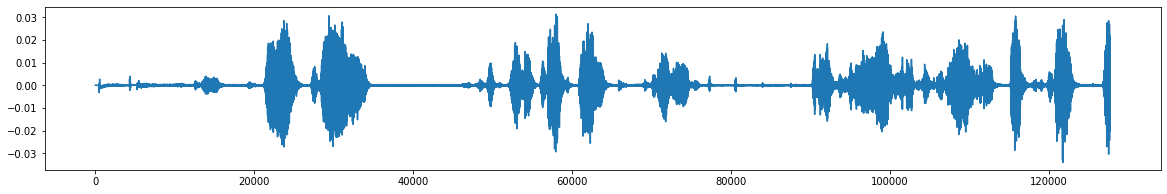

In [16]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

### add noise

In [17]:
#@markdown Either record audio from microphone or upload audio from file (.mp3 or .wav) { run: "auto" }

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =  8 #@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000
global rec_v
rec_v=0

def _apply_vad(audio, boot_time=0, trigger_level=9, **kwargs):
  print('\nVAD applied\n')
  vad_kwargs = dict(locals().copy(), **kwargs)
  vad_kwargs['sample_rate'] = sample_rate
  del vad_kwargs['kwargs'], vad_kwargs['audio']
  audio = vad(torch.flip(audio, ([0])), **vad_kwargs)
  return vad(torch.flip(audio, ([0])), **vad_kwargs)

def _recognize(audio):
  display(Audio(audio, rate=sample_rate, autoplay=True))
  if use_VAD == "Yes":
    audio = _apply_vad(audio)
  wavfile.write('test.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  transcription = wav_to_text()
  print('\n\nTRANSCRIPTION:\n')
  print(transcription)

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  wavfile.write('ٔNoise_recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  _recognize(audio)
  
  rec_v=1
  #while True:
     
  return rec_v

  

def _upload_audio(b):
  clear_output()
  audio = upload_audio()
  _recognize(audio)
  return audio
import keyboard

if True:
   if record_or_upload == "Record":
      button = widgets.Button(description="Record Speech")
      display(button)
      if True :
          button.on_click(_record_audio)
          #if rec_v == "1":

             #break
      #input('press key to continue')
      
      #keyboard.get_event()
      
      #while rec_v!=1:
      #    print ("wating")

   else:
      audio = _upload_audio("")
      rec_v=1

Button(description='Record Speech', style=ButtonStyle())

In [19]:
#@markdown Check audio after applying VAD { run: "auto" }
global rec_v
while True:
  try:
     if record_or_upload == "Record":
        audio = read_audio('ٔNoise_recorded.wav', sample_rate)
     display(Audio(_apply_vad(audio), rate=sample_rate, autoplay=True))
     break
  except :
    print('Please record The non vocal voice as noise or upload the Noise file by above Button ')
    print('لطفاً صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید')
  if rec_v==1:
      rec_v=0
      break

Streaming output truncated to the last 5000 lines.
Please record The non vocal voice as noise or upload the Noise file by above Button 
لطفاً صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید
Please record The non vocal voice as noise or upload the Noise file by above Button 
لطفاً صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید
Please record The non vocal voice as noise or upload the Noise file by above Button 
لطفاً صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید
Please record The non vocal voice as noise or upload the Noise file by above Button 
لطفاً صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید
Please record The non vocal voice as noise or upload the Noise file by above Button 
لطفاً صدای نویز محیط را به صورت نویز ضبط کنید یا فایل نویز را با دکمه بالا آپلود کنید
Please record The non vocal voice as noise or upload the Noise file by above Button 
لطفاً صدا

KeyboardInterrupt: ignored

In [18]:
noise_data, noise_rate = sf.read('/content/silero-models/ٔNoise_recorded.wav')

LibsndfileError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [ ]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [ ]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [ ]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### Stationary remove noise

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

## A more difficult example 

In [ ]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
#response = urllib.request.urlopen(url)
#noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

### add noise to data

In [ ]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

### plot noisy data

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)
IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

### Stationary remove noise

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, y_noise = noise_clip, n_std_thresh_stationary=1.5,stationary=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### ensure that noise reduction does not cause distortion when prop_decrease == 0

In [ ]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

In [ ]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

### Reduce noise over batches in parallel on long signal

In [ ]:
long_data = np.tile(data, 10)
len(long_data)/rate

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(long_data)

In [ ]:
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(long_data), samplerate=rate)*10
audio_clip_band_limited = long_data+noise

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [ ]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=False,
    n_jobs=2,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

In [ ]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=True,
    n_jobs=2,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

### Reduce noise on only a subset of a long clip

In [ ]:
from noisereduce.noisereduce import SpectralGateStationary

In [ ]:
sg = SpectralGateStationary(
    y = data,
    sr = rate,
    y_noise=None,
    prop_decrease=1.0,
    time_constant_s=2.0,
    freq_mask_smooth_hz=500,
    time_mask_smooth_ms=50,
    n_std_thresh_stationary=1.5,
    tmp_folder=None,
    chunk_size=600000,
    padding=30000,
    n_fft=1024,
    win_length=None,
    hop_length=None,
    clip_noise_stationary=True,
    use_tqdm=False,
    n_jobs=1,
)

In [ ]:
subset_noise_reduce = sg.get_traces(start_frame = 10000, end_frame = 20000)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(subset_noise_reduce)

## Multichannel noise

In [ ]:
audio_clip_cafe_2_channel = np.vstack([audio_clip_cafe, audio_clip_cafe])
audio_clip_cafe_2_channel.shape

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe_2_channel, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

In [ ]:
reduced_noise.shape

In [ ]:
fig, axs = plt.subplots(nrows= 2, figsize=(20,5))
axs[0].plot(audio_clip_cafe_2_channel[0])
axs[1].plot(audio_clip_cafe_2_channel[1])

axs[0].plot(reduced_noise[0])
axs[1].plot(reduced_noise[1])

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [ ]:
reduced_noise.shape

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)